In [3]:
from os import listdir
from os.path import isfile, join
import random
from PIL import Image
import math
import numpy as np

import cv2
from matplotlib import pyplot as plt

import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F

width = height = 140

In [4]:
torch.cuda.is_available()

True

In [5]:
def LoadImg(name):
    path = 'GeneratedImages/' + name
    image = Image.open(path)
    angle = path.split('_')[1]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle), path

In [6]:
path = 'GeneratedImages'
files = [f for f in listdir(path) if isfile(join(path, f))]

#randomise the order of the files list
random.shuffle(files)

def LoadRandomImg():
    path = 'GeneratedImages/' + files[random.randrange(0,len(files))]
    image = Image.open(path)
    angle = path.split('_')[1]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle), path

In [7]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(512, 128)
        
        self.branch_a1 = nn.Linear(128, 32)
        self.branch_a2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))

        a = F.leaky_relu(self.branch_a1(x))
        
        out1 = self.branch_a2(a)
        
        return out1

GeneratedImages/dayShadows_0.3444_degrees_x-2y1_crop.jpg


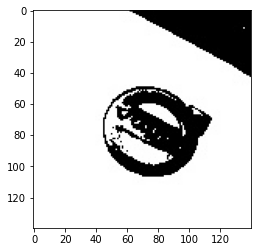

Predicted Steering Angle:  0.4792332
Real Steering Angle:  0.3444


In [9]:
image, angle, path = LoadRandomImg()

print(path)
#Import image
cv2img = cv2.imread(path)

#Show the image with matplotlib
plt.imshow(cv2img)
plt.show()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



resnet18 = torchvision.models.resnet18()
resnet18.fc = nn.Identity()
net_add=net()
model = nn.Sequential(resnet18, net_add)
model = model.to(device)


modelPath = 'bestModel.torch'
model.load_state_dict(torch.load(modelPath))


image = image.to(device).unsqueeze(0)

with torch.no_grad():
    prediction = model(image)  # Run net

print("Predicted Steering Angle: ", prediction.data.cpu().numpy()[0][0])
print("Real Steering Angle: ", angle)